По датасету из вложения построить наилучший бинарный классификатор, целевой столбец – mark. Оформить в виде jupyter notebook либо .py скрипта (тогда вывод должен быть описан в отдельном файле txt/excel/etc.).

По стеку ограничений нет. Срок 1 день.

In [382]:
import torch
import numpy as np
import pandas as pd
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score
import matplotlib.pyplot as plt
import catboost.datasets as cbd
from sklearn.model_selection import GridSearchCV
import math



In [411]:
#dowload data
file_name = 'result_set.xlsx' 
df = pd.read_excel(file_name)
print(df.head())

       Ft 0      Ft 1      Ft 2      Ft 3       Ft 4      Ft 5       Ft 6  \
0  1.620967  1.056248  0.114203  6.175593   5.625789  0.581535   7.360085   
1  1.274494  0.814288  0.727210  3.606359   1.493780  7.810750  20.314335   
2  0.569931  1.607170  0.479581  3.521474   1.663726  2.297903  12.839282   
3  0.547560  1.724393  0.682358  1.809472  10.149721  2.999319  49.108530   
4  1.798884  1.748245  1.045646  1.560427   1.269053  1.403952   5.270951   

   Ft 7    Ft 8      Ft 9  Ft 10  Ft 11  Ft 12  Ft 13  Ft14        Ft15  \
0    68    male  very_low  535.0   True      5      5     0         NaN   
1    24  female      high  846.0  False      3      1     1  quite rich   
2    67    male      high  782.0  False      0      0     0    moderate   
3    42    male    medium  132.0  False      3      3     0  quite rich   
4    84    male  very_low  708.0  False      0      0     0         NaN   

                  Ft16  Ft17  mark  
0                  car     0     0  
1           

In [412]:
# print the size of data
print(df.shape)

(5000, 19)


In [416]:
print(df.isna().sum())


Ft 0       0
Ft 1       0
Ft 2       0
Ft 3       0
Ft 4       0
Ft 5       0
Ft 6       0
Ft 7       0
Ft 8       0
Ft 9       0
Ft 10     64
Ft 11     50
Ft 12      0
Ft 13      0
Ft14       0
Ft15     817
Ft16       0
Ft17       0
mark       0
dtype: int64


In [417]:
print(df.isnull().sum())

Ft 0       0
Ft 1       0
Ft 2       0
Ft 3       0
Ft 4       0
Ft 5       0
Ft 6       0
Ft 7       0
Ft 8       0
Ft 9       0
Ft 10     64
Ft 11     50
Ft 12      0
Ft 13      0
Ft14       0
Ft15     817
Ft16       0
Ft17       0
mark       0
dtype: int64


In [418]:
# replace Nan to NULL because if I drop all NaN, I lost around 20% of data
df = df.fillna('')
df = df.replace('', 'NULL')

print(df.shape)
df.head()


(5000, 19)


,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17,mark
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,True,5,5,0,NULL,car,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,False,3,1,1,quite rich,car,1,0
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1,0
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,False,3,3,0,quite rich,car,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,False,0,0,0,NULL,radio/TV,1,0


In [419]:
# drop target value
X=df.drop('mark', axis=1)
X

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,True,5,5,0,NULL,car,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,False,3,1,1,quite rich,car,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,False,3,3,0,quite rich,car,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,False,0,0,0,NULL,radio/TV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.559134,0.536588,1.279125,0.929000,7.795273,0.516629,3.664827,18,male,high,243.0,False,4,3,0,NULL,car,1
4996,1.857942,0.976926,0.513208,0.707998,0.176079,0.444542,10.778070,78,male,high,643.0,True,2,2,0,moderate,domestic appliances,0
4997,1.207780,0.782006,0.557193,0.186188,1.029377,0.546945,16.717601,70,male,low,690.0,True,5,3,0,little,domestic appliances,0
4998,0.579599,1.191785,0.499301,1.139520,0.080799,0.261127,23.748920,84,female,very_low,498.0,False,5,3,0,little,radio/TV,0


In [420]:
#get target value
target=df['mark']
target

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: mark, Length: 5000, dtype: int64

In [453]:
target.value_counts()

mark
0    4936
1      64
Name: count, dtype: int64

In [421]:
# find all numerical and categorical features 
numeric_indices = np.array([0, 1, 2, 3, 4, 5 ,6, 7, 12, 13, 14, 17])
categorical_indices = np.array([8, 9, 10, 11, 15, 16])

In [422]:
#  look at numerical data
numeric_data = X[X.columns[numeric_indices]]
numeric_data.head()

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 12,Ft 13,Ft14,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,5,5,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,3,1,1,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,0,0,0,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,3,3,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,0,0,0,1


In [423]:
#  look at categorial data
categorial_data = X[X.columns[categorical_indices]]
categorial_data.head()

,Ft 8,Ft 9,Ft 10,Ft 11,Ft15,Ft16
0,male,very_low,535.0,True,NULL,car
1,female,high,846.0,False,quite rich,car
2,male,high,782.0,False,moderate,furniture/equipment
3,male,medium,132.0,False,quite rich,car
4,male,very_low,708.0,False,NULL,radio/TV


In [426]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dummy_features = pd.get_dummies(categorial_data)
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = df.iloc[:, :-1]

data_scaled = scaler.fit_transform(X)
columns_df = X.columns
scaled_X = pd.DataFrame(data_scaled, columns = columns_df)
X = scaled_X
X.head(3)

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 12,Ft 13,...,Ft15_quite rich,Ft15_rich,Ft16_business,Ft16_car,Ft16_domestic appliances,Ft16_education,Ft16_furniture/equipment,Ft16_radio/TV,Ft16_repairs,Ft16_vacation/others
0,0.660678,-0.009069,-1.428346,3.376005,1.172979,-0.631287,-0.460976,0.865384,0.113544,0.155709,...,-0.431229,-0.411149,-0.318311,2.044834,-0.275614,-0.330362,-0.379000,-0.542831,-0.328124,-0.325124
1,0.167223,-0.584034,-0.221576,1.544499,-0.194319,3.579564,0.437681,-1.388167,0.014292,-0.043471,...,2.318955,-0.411149,-0.318311,2.044834,-0.275614,-0.330362,-0.379000,-0.542831,-0.328124,-0.325124
2,-0.836230,1.300082,-0.709060,1.483987,-0.138083,0.368459,-0.080875,0.814167,-0.134585,-0.093266,...,-0.431229,-0.411149,-0.318311,-0.489037,-0.275614,-0.330362,2.638519,-0.542831,-0.328124,-0.325124


In [427]:
#split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, target.values,
                                                       train_size=0.8,
                                                       random_state=42)

In [466]:
clf = catboost.CatBoostClassifier()
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# list a few parameters that we can tune 
param_grid = {
    
    
    'learning_rate': [0.01, 0.03, 0.001],
    'depth': [5,7,9,11],
    'l2_leaf_reg': [4,6,8,10],
    'n_estimators' : [400, 500],
    
}

#  GridSearchCV
search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='f1')

# start to search parameters
search.fit(X_resampled, y_resampled)

# print the best result of GridSearch
print(search.best_params_)

0:	learn: 0.6399339	total: 227ms	remaining: 1m 53s
1:	learn: 0.5895662	total: 459ms	remaining: 1m 54s
2:	learn: 0.5382786	total: 691ms	remaining: 1m 54s
3:	learn: 0.4957039	total: 936ms	remaining: 1m 56s
4:	learn: 0.4554784	total: 1.17s	remaining: 1m 55s
5:	learn: 0.4200491	total: 1.38s	remaining: 1m 54s
6:	learn: 0.3878981	total: 1.61s	remaining: 1m 53s
7:	learn: 0.3666324	total: 1.84s	remaining: 1m 53s
8:	learn: 0.3397436	total: 2.08s	remaining: 1m 53s
9:	learn: 0.3155447	total: 2.3s	remaining: 1m 52s
10:	learn: 0.2963427	total: 2.52s	remaining: 1m 52s
11:	learn: 0.2786517	total: 2.75s	remaining: 1m 51s
12:	learn: 0.2598000	total: 2.97s	remaining: 1m 51s
13:	learn: 0.2445598	total: 3.19s	remaining: 1m 50s
14:	learn: 0.2285072	total: 3.42s	remaining: 1m 50s
15:	learn: 0.2145604	total: 3.64s	remaining: 1m 50s
16:	learn: 0.2016812	total: 3.86s	remaining: 1m 49s
17:	learn: 0.1897097	total: 4.1s	remaining: 1m 49s
18:	learn: 0.1784269	total: 4.33s	remaining: 1m 49s
19:	learn: 0.1679987	tot

In [473]:
# fit model with the best parameters
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

boosting_model = catboost.CatBoostClassifier(class_weights={0: 1, 1:10}, n_estimators=500,
                                              depth = 15, l2_leaf_reg= 6, learning_rate= 0.03, loss_function='Logloss', verbose=0, early_stopping_rounds=10, custom_metric = 'F1' )

boosting_model.fit(X_resampled, y_resampled)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]


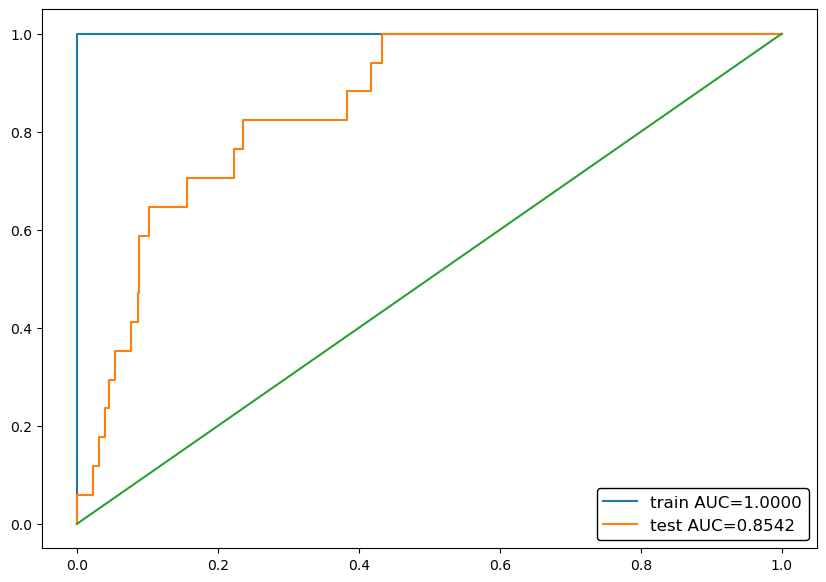

In [474]:
#plot roc_auc metric
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [475]:
y_test_predict = boosting_model.predict(X_test)
y_train_predict = boosting_model.predict(X_train)


In [476]:
#calculate other metrics for train and test data
print('train')
print ( 'Accuracy:', accuracy_score(y_train, y_train_predict))
print ('F1 score:', f1_score(y_train, y_train_predict))
print ('Recall:', recall_score(y_train, y_train_predict))
print ('Precision:', precision_score(y_train, y_train_predict))
print('test')
print ( 'Accuracy:', accuracy_score(y_test, y_test_predict))
print ('F1 score:', f1_score(y_test, y_test_predict))
print ('Recall:', recall_score(y_test, y_test_predict))
print ('Precision:', precision_score(y_test, y_test_predict))

train
Accuracy: 0.99975
F1 score: 0.9894736842105263
Recall: 1.0
Precision: 0.9791666666666666
test
Accuracy: 0.974
F1 score: 0.07142857142857142
Recall: 0.058823529411764705
Precision: 0.09090909090909091


In [471]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       983
           1       0.08      0.06      0.07        17

    accuracy                           0.97      1000
   macro avg       0.53      0.52      0.53      1000
weighted avg       0.97      0.97      0.97      1000



In [472]:
y_predict = boosting_model.predict(X)
print('target')
print ( 'Accuracy:', accuracy_score(target, y_predict))
print ('F1 score:', f1_score(target, y_predict))
print ('Recall:', recall_score(target, y_predict))
print ('Precision:', precision_score(target, y_predict))

target
Accuracy: 0.9942
F1 score: 0.768
Recall: 0.75
Precision: 0.7868852459016393
